<a href="https://colab.research.google.com/github/marioposadas/Adiel13/blob/main/Proyecto_Parte_2_Red_Neuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Conexión e importación de librerías


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [4]:
import os, glob
import pandas as pd


Fuentes de datos

In [5]:
base_path = "/content/drive/MyDrive/Repositorio"

ruta_fuente1 = os.path.join(base_path, "FUENTE1-INE-HECHOS-DELICTIVOS/DELITOS-CONTRA-LIBERTAD-PNC")
ruta_fuente2 = os.path.join(base_path, "FUENTE2-MEDICO-LEGAL-INACIF")
ruta_fuente3 = os.path.join(base_path, "FUENTE3-MEDICO-NECROPCIA-INACIF")
ruta_fuente4 = os.path.join(base_path, "FUENTE4-MEDICO-EXHUMACION-INACIF")

In [6]:
import glob

archivos_fuente1 = glob.glob(os.path.join(ruta_fuente1, "*.xlsx"))
archivos_fuente2 = glob.glob(os.path.join(ruta_fuente2, "*.xlsx"))
archivos_fuente3 = glob.glob(os.path.join(ruta_fuente3, "*.xlsx"))
archivos_fuente4 = glob.glob(os.path.join(ruta_fuente4, "*.xlsx"))

print("Fuente1:", archivos_fuente1[:3])  # muestra primeros 3

Fuente1: ['/content/drive/MyDrive/Repositorio/FUENTE1-INE-HECHOS-DELICTIVOS/DELITOS-CONTRA-LIBERTAD-PNC/DELITOS-CONTRA-LIBERTAD-Por distribucion de delito.xlsx', '/content/drive/MyDrive/Repositorio/FUENTE1-INE-HECHOS-DELICTIVOS/DELITOS-CONTRA-LIBERTAD-PNC/DELITOS-CONTRA-LIBERTAD-Por departamento.xlsx', '/content/drive/MyDrive/Repositorio/FUENTE1-INE-HECHOS-DELICTIVOS/DELITOS-CONTRA-LIBERTAD-PNC/DELITOS-CONTRA-LIBERTAD-Por grupo.xlsx']


In [7]:
import re

def normalizar_nombres(nombres):
    """
    Normaliza nombres de columnas:
    - Elimina tildes y caracteres especiales
    - Sustituye espacios por _
    - Convierte a minúsculas
    """
    nombres = [re.sub(r"[^\w\s]", "", n) for n in nombres]   # elimina puntuación
    nombres = [re.sub(r"\s+", "_", n).lower() for n in nombres]  # espacios -> _
    return nombres

Fuente 1

In [8]:
def leer_fuente1(archivo):
    df = pd.read_excel(archivo, skiprows=2)
    df.columns = [c.lower().replace(" ", "_") for c in df.columns]  # normalización rápida

    if "ano" not in df.columns:
        df.rename(columns={df.columns[0]: "ano"}, inplace=True)

    prefijo = os.path.splitext(os.path.basename(archivo))[0]
    otras_cols = [c for c in df.columns if c != "ano"]
    df.rename(columns={c: f"{prefijo}_{c}" for c in otras_cols}, inplace=True)
    return df

In [9]:
lista_fuente1 = [leer_fuente1(f) for f in archivos_fuente1]

from functools import reduce
datos_fuente1 = reduce(lambda x, y: pd.merge(x, y, on="ano", how="outer"), lista_fuente1)

Fuente 2

In [31]:
import pandas as pd
import os
import unicodedata

# --- Función para normalizar nombres de columnas ---
def normalizar_nombres(cols):
    def limpiar_columna(col):
        # Quitar tildes y caracteres especiales
        col = unicodedata.normalize('NFKD', col).encode('ascii', 'ignore').decode('utf-8')
        # Pasar a minúsculas y reemplazar espacios por guiones bajos
        col = col.lower().replace(" ", "_")
        return col
    return [limpiar_columna(c) for c in cols]

# --- Función para leer y limpiar fuente 2 ---
def leer_fuente2(archivo):
    df = pd.read_excel(archivo)
    df.columns = normalizar_nombres(df.columns)

    # Renombrar columnas específicas si existen
    if "eva_ml" in df.columns:
        df.rename(columns={"eva_ml": "clasif_eval"}, inplace=True)
    if "sexo_per_eva" in df.columns:
        df.rename(columns={"sexo_per_eva": "sexo_per"}, inplace=True)

    # Agregar columna fuente con el nombre del archivo
    df["fuente"] = os.path.basename(archivo)
    return df

# --- Concatenar todos los archivos de fuente 2 ---
datos_fuente2 = pd.concat([leer_fuente2(f) for f in archivos_fuente2], ignore_index=True)

# Verificar columnas unificadas
print(datos_fuente2.columns)


Index(['num_corre', 'ano_ocu', 'mes_ocu', 'dia_ocu', 'dia_sem_ocu',
       'depto_ocu', 'edad_per', 'g_edad_60ymas', 'g_edad_80ymas',
       'edad_quinquenales', 'menor_mayor', 'sexo_per', 'clasif_eval',
       'fuente'],
      dtype='object')


Fuente 3

In [11]:
def unificar_nombres(nombres):
    reemplazos = {
        "causa_muerte": "eva_mn",
        "ano_ing": "ano_ocu",
        "mes_ing": "mes_ocu",
        "dia_ing": "dia_ocu",
        "dia_sem_ing": "dia_sem_ocu",
        "sexo_per": "sexo_per_eva"
    }
    return [reemplazos.get(n, n) for n in nombres]

def leer_fuente3(archivo):
    df = pd.read_excel(archivo)
    df.columns = normalizar_nombres(df.columns)

    # Excluir columna no comparable
    if "g_edad_ninez_adolescencia" in df.columns:
        df.drop(columns=["g_edad_ninez_adolescencia"], inplace=True)

    df.columns = unificar_nombres(df.columns)
    df["fuente"] = os.path.basename(archivo)
    return df

lista_fuente3 = [leer_fuente3(f) for f in archivos_fuente3]

# Alinear columnas
todas_columnas = set().union(*[df.columns for df in lista_fuente3])
datos_fuente3 = pd.concat([df.reindex(columns=todas_columnas) for df in lista_fuente3], ignore_index=True)

Fuente 4

In [12]:
# Detectar columnas comunes
encabezados_fuente4 = []
for f in archivos_fuente4:
    cols = pd.read_excel(f, nrows=0).columns
    encabezados_fuente4.append(normalizar_nombres(cols))

columnas_comunes = set(encabezados_fuente4[0]).intersection(*encabezados_fuente4[1:])

def leer_fuente4(archivo, columnas_objetivo):
    df = pd.read_excel(archivo)
    df.columns = normalizar_nombres(df.columns)
    df = df[list(columnas_objetivo)]
    df["fuente"] = os.path.basename(archivo)
    return df

datos_fuente4 = pd.concat([leer_fuente4(f, columnas_comunes) for f in archivos_fuente4], ignore_index=True)

# RED NEURONAL

Situación 1: predecir sexo de la persona por herida de arma blanca en depto guatemala

Total de registros filtrados: 1887


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5063 - loss: 0.7279 - val_accuracy: 0.5079 - val_loss: 0.6906
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5381 - loss: 0.6949 - val_accuracy: 0.5132 - val_loss: 0.6867
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5705 - loss: 0.6796 - val_accuracy: 0.5291 - val_loss: 0.6798
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5893 - loss: 0.6761 - val_accuracy: 0.5661 - val_loss: 0.6722
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5710 - loss: 0.6807 - val_accuracy: 0.5106 - val_loss: 0.6922
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5700 - loss: 0.6778 - val_accuracy: 0.5238 - val_loss: 0.6888
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5750 - loss: 0.6788 - val_accuracy: 0.4868 - val_loss: 0.6927
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5875 - loss: 0.6689 - val_accuracy: 0.5053 - val_lo

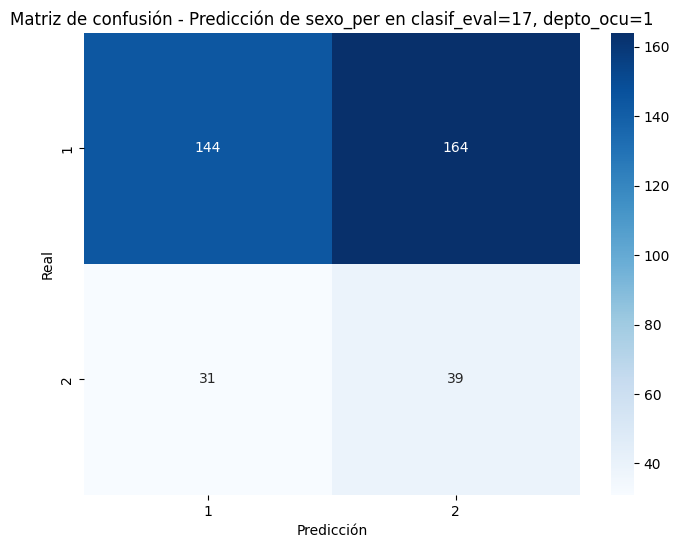

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# --- 1. Filtrar dataset ---
df_filtrado = datos_fuente2[(datos_fuente2["clasif_eval"] == 17) & (datos_fuente2["depto_ocu"] == 1)]
print(f"Total de registros filtrados: {len(df_filtrado)}")

# --- 2. Features y etiquetas ---
X = df_filtrado.drop(columns=["clasif_eval", "sexo_per"])  # usamos todas las columnas excepto la etiqueta y clasif_eval
y = df_filtrado["sexo_per"]

# --- 3. Codificar columnas categóricas en X ---
for col in X.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# --- 4. Codificar etiqueta (sexo_per) ---
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)

# --- 5. Split train/test ---
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# --- 6. Oversampling ---
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# --- 7. Normalizar ---
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# --- 8. Definir modelo ---
num_classes = len(encoder.classes_)
model = Sequential([
    Dense(64, activation="relu", input_shape=(X_resampled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

# --- 9. Compilar ---
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# --- 10. Entrenar ---
history = model.fit(
    X_resampled, y_resampled,
    validation_data=(X_test_scaled, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

# --- 11. Evaluar ---
loss, acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Accuracy en test: {acc:.2f}")

# --- 12. Predicciones ---
y_pred = model.predict(X_test_scaled)
y_pred_classes = y_pred.argmax(axis=1)

# --- 13. Reporte de clasificación ---
print(classification_report(y_test, y_pred_classes, target_names=[str(c) for c in encoder.classes_]))

# --- 14. Matriz de confusión ---
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Matriz de confusión - Predicción de sexo_per en clasif_eval=17, depto_ocu=1")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


Situación 2: Predicción de grupo de edad para departamento de Guatemala y arma blanca

Epoch 1/20


/tmp/ipython-input-3051158115.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["grupo_edad"] = df_filtrado["edad_per"].apply(categorizar_edad)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4328 - loss: 1.2247 - val_accuracy: 0.7302 - val_loss: 0.7138
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7198 - loss: 0.7189 - val_accuracy: 0.7593 - val_loss: 0.5586
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7314 - loss: 0.6237 - val_accuracy: 0.8069 - val_loss: 0.4930
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7728 - loss: 0.5572 - val_accuracy: 0.8466 - val_loss: 0.4343
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8011 - loss: 0.4918 - val_accuracy: 0.8571 - val_loss: 0.3870
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8248 - loss: 0.4588 - val_accuracy: 0.8651 - val_loss: 0.3421
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8561 - loss: 0.3888 - val_accuracy: 0.8677 - val_loss: 0.3088
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8597 - loss: 0.3580 - val_accuracy: 0.8677 - val_loss: 0.2881
Epo

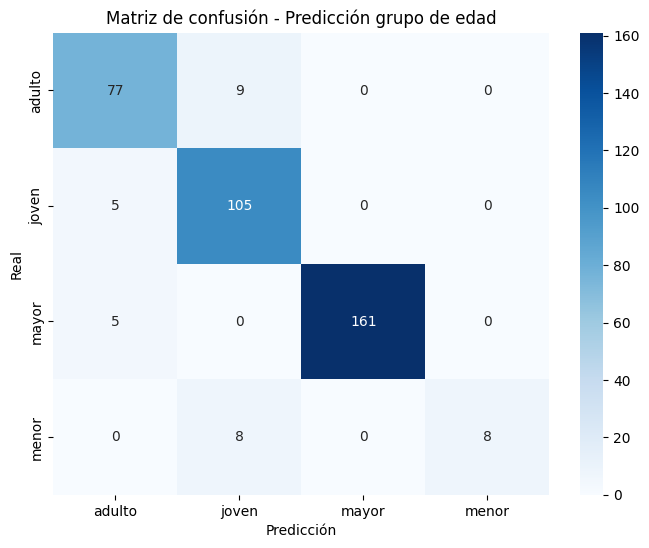

In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# --- 1. Filtrar dataset ---
df_filtrado = datos_fuente2[(datos_fuente2["clasif_eval"] == 17) & (datos_fuente2["depto_ocu"] == 1)]

# --- 2. Crear etiqueta a partir de edad_per ---
def categorizar_edad(edad):
    if edad <= 17:
        return "menor"
    elif edad <= 30:
        return "joven"
    elif edad <= 50:
        return "adulto"
    else:
        return "mayor"

df_filtrado["grupo_edad"] = df_filtrado["edad_per"].apply(categorizar_edad)

# --- 3. Features y etiquetas ---
X = df_filtrado.drop(columns=["clasif_eval", "edad_per", "grupo_edad"])
y = df_filtrado["grupo_edad"]

# --- 4. Codificar columnas categóricas ---
for col in X.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# --- 5. Codificar etiqueta ---
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)

# --- 6. Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# --- 7. Normalizar ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 8. Definir modelo ---
num_classes = len(encoder.classes_)
model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

# --- 9. Compilar ---
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# --- 10. Entrenar ---
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

# --- 11. Evaluar ---
loss, acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Accuracy en test: {acc:.2f}")

# --- 12. Predicciones ---
y_pred = model.predict(X_test_scaled)
y_pred_classes = y_pred.argmax(axis=1)

# --- 13. Reporte de clasificación ---
print(classification_report(y_test, y_pred_classes, target_names=encoder.classes_))

# --- 14. Matriz de confusión ---
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Matriz de confusión - Predicción grupo de edad")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


Situación 3: Predicción de grupo de edad y sexo por herida de arma blanca en el departamento de Guatemala

Epoch 1/20


/tmp/ipython-input-2001636154.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["grupo_edad"] = df_filtrado["edad_per"].apply(categorizar_edad)


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - edad_accuracy: 0.5743 - edad_loss: 1.1301 - loss: 1.6955 - sexo_accuracy: 0.7453 - sexo_loss: 0.5651 - val_edad_accuracy: 0.7540 - val_edad_loss: 0.7321 - val_loss: 1.1730 - val_sexo_accuracy: 0.8598 - val_sexo_loss: 0.4375
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - edad_accuracy: 0.7644 - edad_loss: 0.6856 - loss: 1.2544 - sexo_accuracy: 0.7766 - sexo_loss: 0.5684 - val_edad_accuracy: 0.8016 - val_edad_loss: 0.5405 - val_loss: 0.9606 - val_sexo_accuracy: 0.8598 - val_sexo_loss: 0.4175
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - edad_accuracy: 0.8136 - edad_loss: 0.5185 - loss: 1.0428 - sexo_accuracy: 0.8015 - sexo_loss: 0.5240 - val_edad_accuracy: 0.8386 - val_edad_loss: 0.4567 - val_loss: 0.8868 - val_sexo_accuracy: 0.8598 - val_sexo_loss: 0.4276
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - edad_accuracy: 0.8320 - edad_loss: 0.5006 - loss: 1.0138 - sexo_accuracy: 0.8014 - sexo_loss: 0.5135 - val_edad_accuracy: 0.8439 -

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


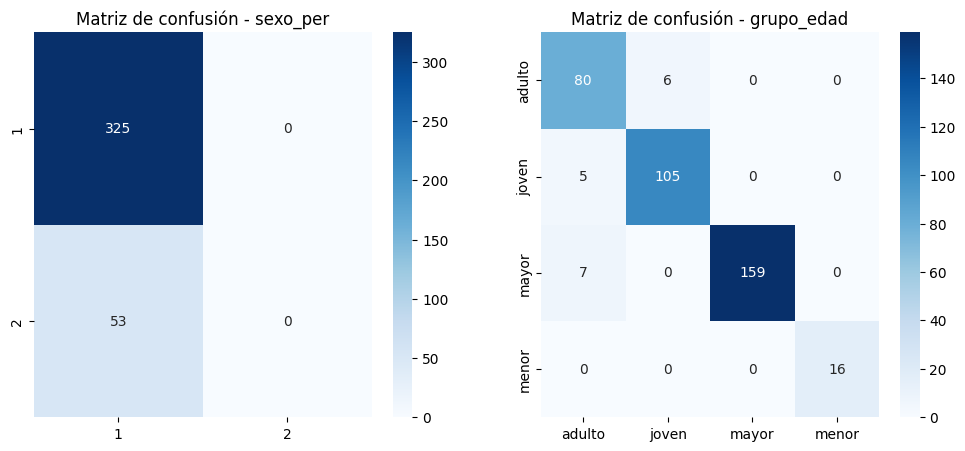

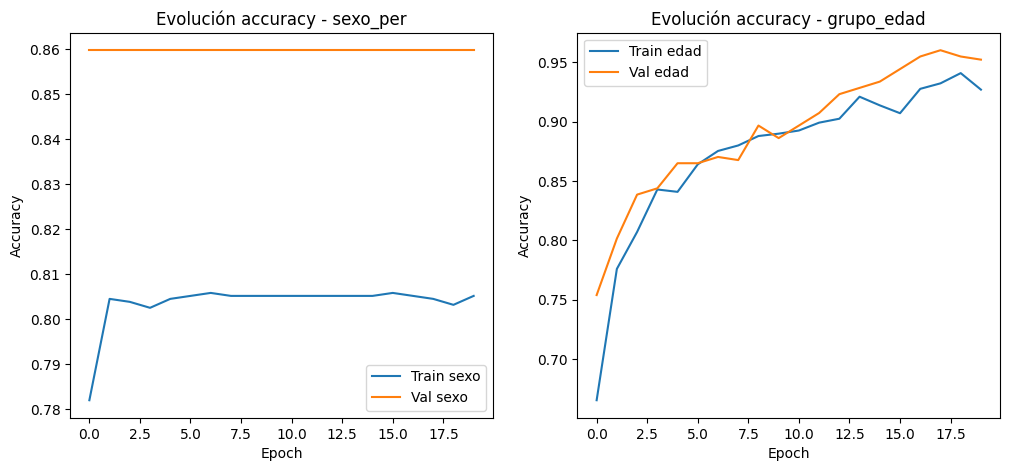

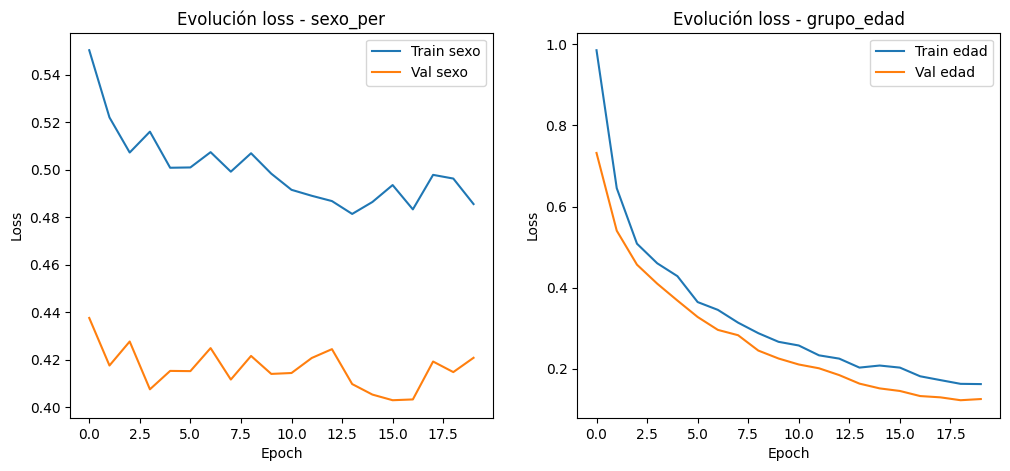

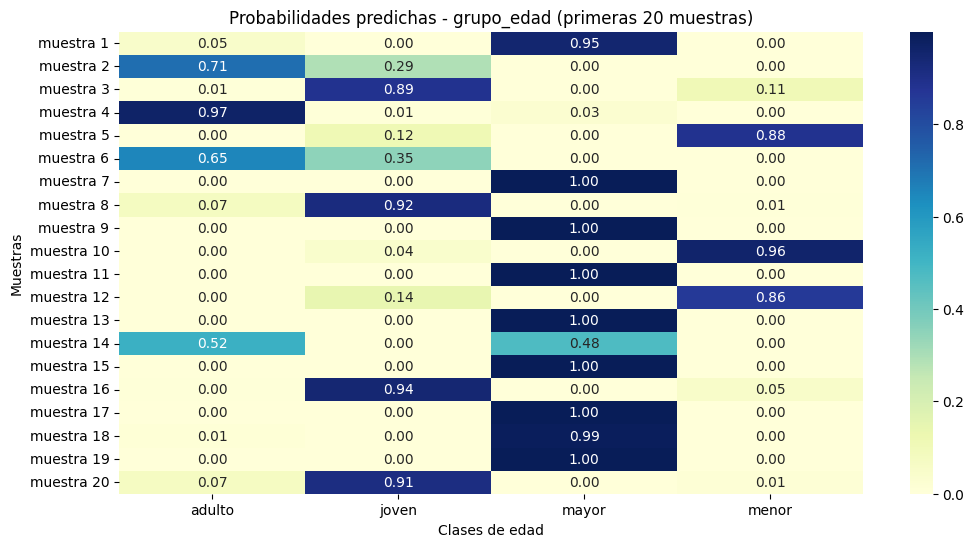

In [44]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

# --- 1. Filtrar dataset ---
df_filtrado = datos_fuente2[(datos_fuente2["clasif_eval"] == 17) & (datos_fuente2["depto_ocu"] == 1)]

# --- 2. Crear etiqueta de grupo de edad ---
def categorizar_edad(edad):
    if edad <= 17:
        return "menor"
    elif edad <= 30:
        return "joven"
    elif edad <= 50:
        return "adulto"
    else:
        return "mayor"

df_filtrado["grupo_edad"] = df_filtrado["edad_per"].apply(categorizar_edad)

# --- 3. Features y etiquetas ---
X = df_filtrado.drop(columns=["clasif_eval", "sexo_per", "edad_per", "grupo_edad"])
y_sexo = df_filtrado["sexo_per"]
y_edad = df_filtrado["grupo_edad"]

# --- 4. Codificar columnas categóricas ---
for col in X.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# --- 5. Codificar etiquetas ---
encoder_sexo = LabelEncoder()
y_sexo_enc = encoder_sexo.fit_transform(y_sexo)

encoder_edad = LabelEncoder()
y_edad_enc = encoder_edad.fit_transform(y_edad)

# --- 6. Split train/test ---
X_train, X_test, y_sexo_train, y_sexo_test, y_edad_train, y_edad_test = train_test_split(
    X, y_sexo_enc, y_edad_enc, test_size=0.2, random_state=42, stratify=y_edad_enc
)

# --- 7. Normalizar ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 8. Definir modelo multitarea ---
inputs = Input(shape=(X_train_scaled.shape[1],))
x = Dense(64, activation="relu")(inputs)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)

# Salida 1: sexo_per
out_sexo = Dense(len(encoder_sexo.classes_), activation="softmax", name="sexo")(x)

# Salida 2: grupo_edad
out_edad = Dense(len(encoder_edad.classes_), activation="softmax", name="edad")(x)

model = Model(inputs=inputs, outputs=[out_sexo, out_edad])

# --- 9. Compilar ---
model.compile(optimizer="adam",
              loss={"sexo": "sparse_categorical_crossentropy", "edad": "sparse_categorical_crossentropy"},
              metrics={"sexo": "accuracy", "edad": "accuracy"})

# --- 10. Entrenar ---
history = model.fit(
    X_train_scaled, {"sexo": y_sexo_train, "edad": y_edad_train},
    validation_data=(X_test_scaled, {"sexo": y_sexo_test, "edad": y_edad_test}),
    epochs=20,
    batch_size=32,
    verbose=1
)

# --- 11. Evaluar ---
results = model.evaluate(X_test_scaled, {"sexo": y_sexo_test, "edad": y_edad_test}, verbose=0)
print("Resultados evaluate:", results)
print("Metric names:", model.metrics_names)

# --- 12. Predicciones ---
y_pred_sexo, y_pred_edad = model.predict(X_test_scaled)
y_pred_sexo_classes = y_pred_sexo.argmax(axis=1)
y_pred_edad_classes = y_pred_edad.argmax(axis=1)

# --- 13. Reportes de clasificación ---
print("Reporte sexo_per:")
print(classification_report(y_sexo_test, y_pred_sexo_classes, target_names=[str(c) for c in encoder_sexo.classes_]))

print("Reporte grupo_edad:")
print(classification_report(y_edad_test, y_pred_edad_classes, target_names=encoder_edad.classes_))

# --- 14. Matrices de confusión ---
cm_sexo = confusion_matrix(y_sexo_test, y_pred_sexo_classes)
cm_edad = confusion_matrix(y_edad_test, y_pred_edad_classes)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm_sexo, annot=True, cmap="Blues", fmt="d",
            xticklabels=encoder_sexo.classes_, yticklabels=encoder_sexo.classes_)
plt.title("Matriz de confusión - sexo_per")

plt.subplot(1,2,2)
sns.heatmap(cm_edad, annot=True, cmap="Blues", fmt="d",
            xticklabels=encoder_edad.classes_, yticklabels=encoder_edad.classes_)
plt.title("Matriz de confusión - grupo_edad")
plt.show()

# --- 15. Gráficas de evolución ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['sexo_accuracy'], label='Train sexo')
plt.plot(history.history['val_sexo_accuracy'], label='Val sexo')
plt.title("Evolución accuracy - sexo_per")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['edad_accuracy'], label='Train edad')
plt.plot(history.history['val_edad_accuracy'], label='Val edad')
plt.title("Evolución accuracy - grupo_edad")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['sexo_loss'], label='Train sexo')
plt.plot(history.history['val_sexo_loss'], label='Val sexo')
plt.title("Evolución loss - sexo_per")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['edad_loss'], label='Train edad')
plt.plot(history.history['val_edad_loss'], label='Val edad')
plt.title("Evolución loss - grupo_edad")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# --- 16. Gráfico de probabilidades predichas (ejemplo grupo_edad) ---
probs = y_pred_edad[:20]  # primeras 20 muestras

plt.figure(figsize=(12,6))
sns.heatmap(probs, annot=True, cmap="YlGnBu", fmt=".2f",
            xticklabels=encoder_edad.classes_,
            yticklabels=[f"muestra {i}" for i in range(1,21)])
plt.title("Probabilidades predichas - grupo_edad (primeras 20 muestras)")
plt.xlabel("Clases de edad")
plt.ylabel("Muestras")
plt.show()
